In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
using Zygote
using LaTeXStrings
using MultiFloats
using SparseIR
using Nevanlinna

┌ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]
└ @ Base loading.jl:1662


In [2]:
T = BigFloat

BigFloat

In [3]:
beta::Float64 = 100
wmax::Float64 = 100
basis = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) 

FiniteTempBasisSet with β = 100.0, ωmax = 100.0

In [4]:
include("../flex_src/IRFLEX.jl")

Main.IRFLEX

In [5]:
nsize::Int64 = 2048
t_pra::Float64 = 0.0
filling::Float64 = 1.0
scale::Float64 = 0.1
#U::Float64 = 0.4 ##w=4
#U::Float64 = 0.2 ##w=2
U::Float64 = 0.1 ##w=1
function single_Hami(x::Float64, y::Float64, t::Float64, t_pra::Float64)::Float64
    e::Float64 = -2.0*t*(cos(x)+cos(y)) + 4.0*t_pra*cos(x)*cos(y)                   
end
hami::Function = (x,y) -> single_Hami(x,y,0.125,t_pra)
#U::Float64 = 0.5
#hami::Function = (x,y) -> IRFLEX.single_Hami(x,y,t_pra)
lat = IRFLEX.SingleLatticeModel(nsize, filling, U, SparseIR.β(basis), hami)
;

In [6]:
ratio_U = 0.0
precision = 1e-4
loose_precision = 1e+3*precision
gkf0 = IRFLEX.make_free_giw(lat, basis)
;

In [7]:
# Compute chi0
chi0kf = IRFLEX.calc_chi0(gkf0, lat, basis)
;

In [8]:
# Compute chi
chiskf = chi0kf ./ (1.0 .- lat.U*chi0kf)
;

In [9]:
hnw = (length(basis.smpl_wn_b.sampling_points)-1)÷2

52

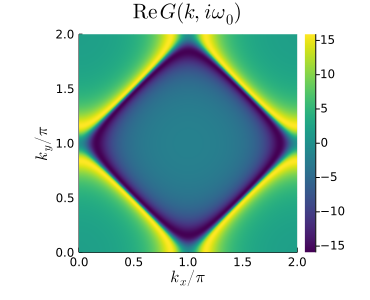

In [10]:
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(gkf0[hnw+1,:,:]), 
    title=latexstring("\\mathrm{Re}\\,G(k,i\\omega_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"), 
    c=:viridis, 
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

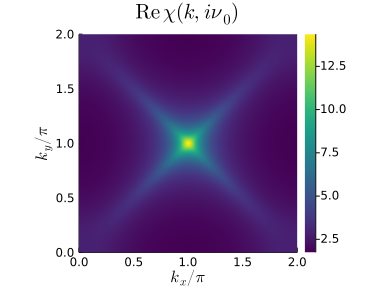

In [11]:
# plot 2D k-dependence of lowest Matsubara frequency of e.g. chi0
myx = (2 .* collect(1:nsize) .- 1) ./ nsize
myy = (2 .* collect(1:nsize) .- 1) ./ nsize
heatmap(myx, myy, real.(chiskf[hnw+1,:,:]),
    title=latexstring("\\mathrm{Re}\\,\\chi(k,i\\nu_0)"), xlabel=latexstring("k_x/\\pi"), ylabel=latexstring("k_y/\\pi"),
    c=:viridis,
    xlim = (0,2), ylim = (0,2), aspect_ratio=1.0, size=(370,300))

In [12]:
#smpl_wn_b = SparseIR.default_matsubara_sampling_points(basis.basis_b)
#smpl_wn_b = smpl_wn_b[smpl_wn_b .!= BosonicFreq(0)]
#smpl_wn_b_wo_zero = MatsubaraSampling(basis.basis_b, smpl_wn_b)
;

In [13]:
chisf = chi0kf[:,nsize÷2+1, nsize÷2+1]
#deleteat!(chisf, hnw+1)
#chisl = fit(smpl_wn_b_wo_zero, chisf, dim=1)
#chisf[37] = 0
chisl = fit(basis.smpl_wn_b, chisf, dim=1)
;

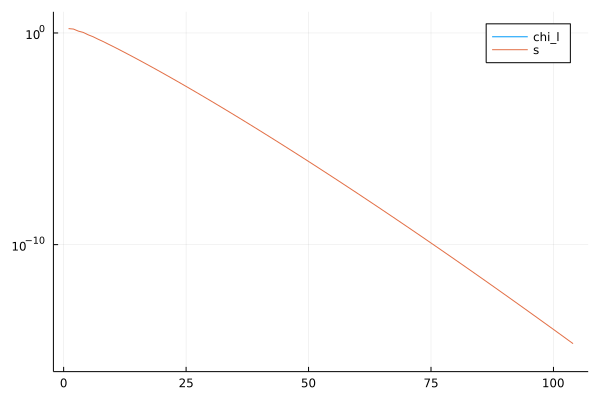

In [14]:
plot(yaxis=:log,ylims=(1e-16,10))
#plot()
plot!(real.(chisl),label="chi_l")
plot!(real.(basis.basis_b.s),label="s")

In [15]:
#smpl_wn_b_dense = MatsubaraSampling(basis.basis_b, SparseIR.BosonicFreq.(collect(-2332:2:2332)))
#chisl_d = fit(basis.smpl_wn_b, chisf)
#chisf_d = evaluate(smpl_wn_b_dense, chisl_d)
#deleteat!(chisf_d, 1167)
#chisf_d[1167]=0.0
#chisl_d = fit(smpl_wn_b_dense, chisf_d)
;

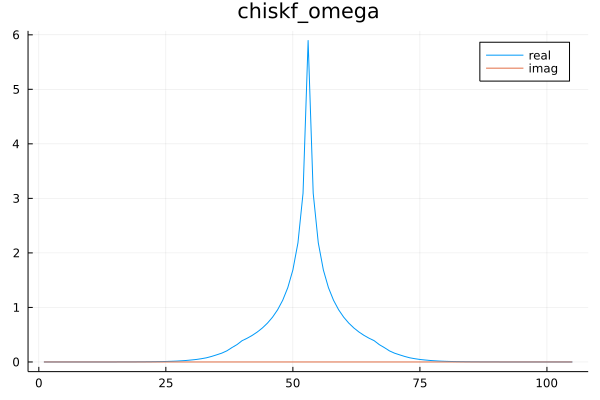

In [16]:
plot(title="chiskf_omega")
plot!(real.(chisf), label="real")
plot!(imag.(chisf), label="imag")

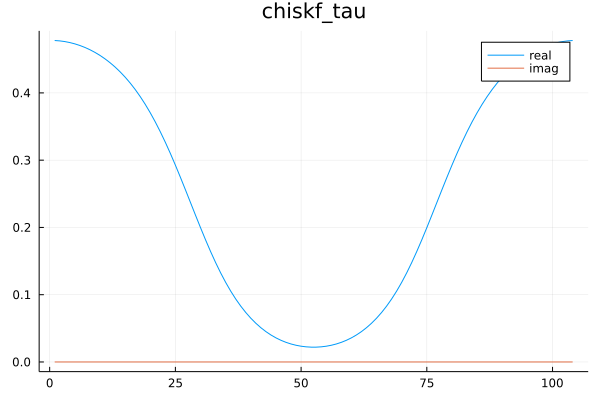

In [17]:
chist = evaluate(basis.smpl_tau_b, chisl)
plot(title="chiskf_tau")
plot!(real.(chist[:]), label="real")
plot!(imag.(chist[:]), label="imag")

In [18]:
chisw = evaluate(basis.smpl_wn_f, chisl)
;

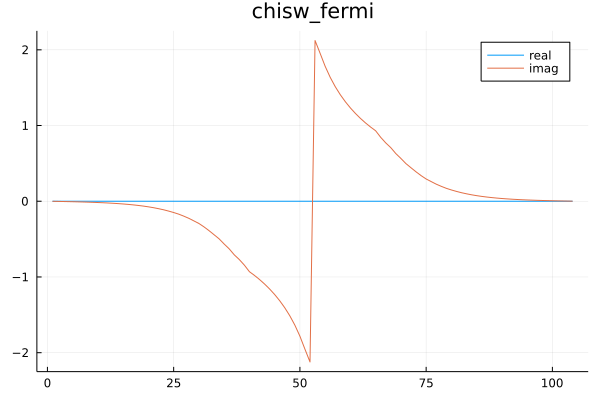

In [19]:
plot(title="chisw_fermi")
plot!(real.(chisw[:]), label="real")
plot!(imag.(chisw[:]), label="imag")

In [20]:
setprecision(512)

512

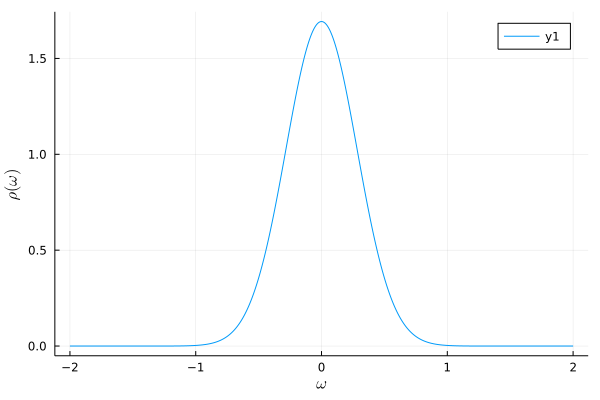

In [21]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
weight = 1.2
rho(omega) = weight*gaussian(omega, 0.0, 0.4)  
#+ 0.5*gaussian(omega, 0.0, 0.1) 
#rho(omega) = weight*gaussian(omega, 0.0, 0.1)  
omegas = LinRange(-2, 2, 1000)
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [22]:
#sum_rule = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl)) + weight 
sum_rule = real(dot(basis.basis_f.u(SparseIR.β(basis)), chisl) + dot(basis.basis_f.u(0), chisl)) 

0.9560264200788787

In [23]:
rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
gl = - basis.basis_f.s .* rhol
gw = evaluate(basis.smpl_wn_f, gl)
;

In [24]:
input_chi  = Array{Complex{T}}(undef, hnw) 
input_smpl = Array{Complex{T}}(undef, hnw) 
;

In [25]:
for i in 1:hnw
    input_smpl[i] = SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(basis))
    #input_chi[i]  = -chisw[hnw+i] + gw[hnw+i]
    input_chi[i]  = -chisw[hnw+i] 
end

In [51]:
N_real    =  6000
omega_max =  2.0
eta       =  0.001
H_max     =  13
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
#1000 → 2000
iter_tol  = 10000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, input_smpl, input_chi)
println("N_imag $(N_imag)")

N_imag is setted as 18
N_imag 18


In [52]:
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum_rule, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


true

In [46]:
function exact_suscep(qx, qy, omega, nsize, beta, hami)
    chi = zeros(ComplexF64, length(omega))
    for iomega in 1:length(omega)
        for ix in 1:nsize, iy in 1:nsize
            kx::Float64 = 2*π*(ix-1)/nsize
            ky::Float64 = 2*π*(iy-1)/nsize
            ek  = hami(kx,ky)
            ekq = hami(kx-qx,ky-qy)
            chi[iomega] += -(IRFLEX.fermi_dirac(ekq,beta)-IRFLEX.fermi_dirac(ek,beta))/(omega[iomega]+ekq-ek)
        end
        chi[iomega] = chi[iomega]/(nsize*nsize)
    end
    return chi
end

exact_suscep (generic function with 1 method)

In [29]:
exa_freq = Array{Complex{T}}(collect(LinRange(-omega_max, omega_max, 1000))) .+ eta * im
exa_chi = exact_suscep(π,π,ComplexF64.(exa_freq),nsize,SparseIR.β(basis),hami)
;

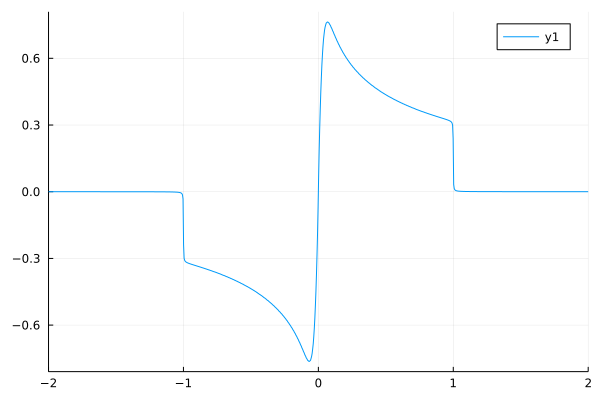

In [30]:
plot(xlim = [-2,2])
plot!(real.(exa_freq), imag.(exa_chi)/pi)

In [31]:
exa_chis = exa_chi ./ (1.0 .- lat.U*exa_chi)
;

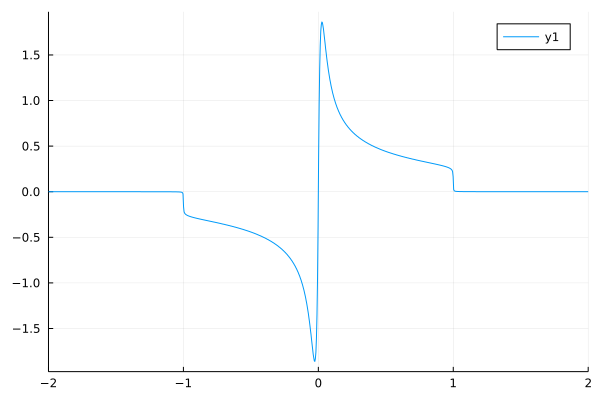

In [32]:
plot(xlim = [-2,2])
plot!(real.(exa_freq), imag.(exa_chis)/pi)

In [53]:
imaginary = Nevanlinna.ImagDomainData(input_smpl, input_chi, N_imag)
sol_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum_rule, T=T)

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, sol_reals, phis)
zero_ab_coeff = zeros(ComplexF64, 2*H_max)
sol_hardy_matrix = Nevanlinna.calc_hardy_matrix(sol_reals, H_max)

sol_reals, res, causality, optim = Nevanlinna.Nevanlinna_Schur(sol_reals, abcd, H_max, zero_ab_coeff, sol_hardy_matrix, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
Iter     Function value   Gradient norm 
     0     3.045589e+02     1.105940e+03
 * time: 0.00019502639770507812
     1     1.102295e+02     4.291717e+02
 * time: 25.58780789375305
     2     1.052616e+02     4.087615e+02
 * time: 32.89777994155884
     3     1.050665e+02     4.034969e+02
 * time: 37.57128190994263
     4     1.045959e+02     4.070704e+02
 * time: 41.039040088653564
     5     1.020916e+02     4.156503e+02
 * time: 47.38934803009033
     6     9.901906e+01     3.996383e+02
 * time: 52.204349994659424
     7     9.675062e+01     3.794401e+02
 * time: 55.668752908706665
     8     9.638028e+01     3.880754e+02
 * time: 62.80894207954407
     9     9.416818e+01     3.648175e+02
 * time: 66.3252420425415
    10     9.271410e+01     3.663801e+02
 * time: 71.29702305793762
    11     9.063547e+01     3.570012e+02
 * time: 79.21629405021667
    12     8.880729e+01     3.588896e+02
 * time: 82.58129906654358
    13     8.794785e+01     3

   119     1.226567e-02     8.088519e-03
 * time: 574.2098319530487
   120     1.225686e-02     1.171792e-02
 * time: 577.6223919391632
   121     1.224671e-02     1.233140e-02
 * time: 580.5204660892487
   122     1.220690e-02     1.581709e-02
 * time: 589.7119929790497
   123     1.218186e-02     1.452082e-02
 * time: 599.8833608627319
   124     1.217791e-02     1.089094e-02
 * time: 602.1244819164276
   125     1.217134e-02     9.097400e-03
 * time: 604.5939929485321
   126     1.209838e-02     2.384115e-02
 * time: 610.0303108692169
   127     1.200166e-02     2.355802e-02
 * time: 613.412328004837
   128     1.183749e-02     2.219804e-02
 * time: 621.7798800468445
   129     1.182085e-02     2.158003e-02
 * time: 625.1534469127655
   130     1.172734e-02     9.295290e-03
 * time: 627.6771099567413
   131     1.171395e-02     5.461050e-03
 * time: 630.3415789604187
   132     1.168971e-02     9.171899e-03
 * time: 635.5653910636902
   133     1.167331e-02     9.429550e-03
 * time:

   240     1.066782e-02     2.647993e-03
 * time: 1030.6211450099945
   241     1.065121e-02     2.488026e-03
 * time: 1032.9375400543213
   242     1.059380e-02     4.874191e-03
 * time: 1043.530413866043
   243     1.051774e-02     3.727071e-03
 * time: 1048.1400048732758
   244     1.038207e-02     6.895064e-03
 * time: 1053.6069068908691
   245     1.024989e-02     5.756319e-03
 * time: 1056.9752159118652
   246     1.017155e-02     7.377404e-03
 * time: 1063.334007024765
   247     9.947811e-03     3.177874e-02
 * time: 1068.5748739242554
   248     9.870781e-03     2.177668e-02
 * time: 1072.3003509044647
   249     9.500490e-03     2.466035e-02
 * time: 1076.2709028720856
   250     9.265057e-03     3.034059e-02
 * time: 1082.7444920539856
   251     9.186927e-03     3.511651e-02
 * time: 1095.0361649990082
   252     9.150589e-03     3.232485e-02
 * time: 1099.794084072113
   253     9.040834e-03     1.577787e-02
 * time: 1104.5480780601501
   254     9.025756e-03     7.749290e

   360     8.771327e-03     5.467084e-06
 * time: 1418.7236518859863
   361     8.771327e-03     5.998116e-06
 * time: 1423.038873910904
   362     8.771327e-03     6.102943e-06
 * time: 1425.3918449878693
   363     8.771327e-03     6.809124e-06
 * time: 1427.6365759372711
   364     8.771327e-03     6.783081e-06
 * time: 1430.1685659885406
   365     8.771327e-03     7.648683e-06
 * time: 1434.2783510684967
   366     8.771327e-03     7.492163e-06
 * time: 1436.5215759277344
   367     8.771327e-03     8.454414e-06
 * time: 1438.7847180366516
   368     8.771327e-03     8.195130e-06
 * time: 1441.1235649585724
   369     8.771327e-03     9.173043e-06
 * time: 1444.0236148834229
   370     8.771327e-03     8.855946e-06
 * time: 1448.0999500751495
   371     8.771327e-03     9.766585e-06
 * time: 1450.584969997406
   372     8.771327e-03     9.453361e-06
 * time: 1452.9732809066772
   373     8.771327e-03     1.022308e-05
 * time: 1455.4152610301971
   374     8.771327e-03     9.986781

   480     8.771325e-03     4.926624e-05
 * time: 1757.13973903656
   481     8.771325e-03     4.995319e-05
 * time: 1759.600704908371
   482     8.771325e-03     5.022538e-05
 * time: 1764.4065730571747
   483     8.771325e-03     5.092182e-05
 * time: 1766.6557590961456
   484     8.771325e-03     5.118797e-05
 * time: 1768.9186658859253
   485     8.771325e-03     5.189350e-05
 * time: 1771.6013650894165
   486     8.771324e-03     5.215868e-05
 * time: 1774.4747750759125
   487     8.771324e-03     5.287411e-05
 * time: 1778.183974981308
   488     8.771324e-03     5.314279e-05
 * time: 1780.4242758750916
   489     8.771324e-03     5.387039e-05
 * time: 1782.6674320697784
   490     8.771324e-03     5.414543e-05
 * time: 1785.155560016632
   491     8.771324e-03     5.488861e-05
 * time: 1789.4909529685974
   492     8.771324e-03     5.517067e-05
 * time: 1791.992588043213
   493     8.771324e-03     5.593340e-05
 * time: 1794.3106830120087
   494     8.771324e-03     5.622098e-05

   600     8.771316e-03     1.326183e-04
 * time: 2096.282404899597
   601     8.771316e-03     1.341923e-04
 * time: 2098.620181083679
   602     8.771315e-03     1.345265e-04
 * time: 2100.8731429576874
   603     8.771315e-03     1.361198e-04
 * time: 2103.755306005478
   604     8.771315e-03     1.364566e-04
 * time: 2108.019577026367
   605     8.771315e-03     1.380695e-04
 * time: 2110.2945790290833
   606     8.771315e-03     1.384086e-04
 * time: 2112.9548859596252
   607     8.771315e-03     1.400419e-04
 * time: 2115.5083270072937
   608     8.771315e-03     1.403825e-04
 * time: 2119.7832849025726
   609     8.771314e-03     1.420370e-04
 * time: 2122.02205491066
   610     8.771314e-03     1.423783e-04
 * time: 2124.267054080963
   611     8.771314e-03     1.440545e-04
 * time: 2126.507754087448
   612     8.771314e-03     1.443953e-04
 * time: 2129.447953939438
   613     8.771314e-03     1.460940e-04
 * time: 2133.3643589019775
   614     8.771314e-03     1.464331e-04
 *

   720     8.771281e-03     2.934955e-04
 * time: 2444.923127889633
   721     8.771281e-03     2.974166e-04
 * time: 2449.051344871521
   722     8.771280e-03     2.971772e-04
 * time: 2451.787824869156
   723     8.771280e-03     3.011651e-04
 * time: 2454.248426914215
   724     8.771279e-03     3.009001e-04
 * time: 2456.824397087097
   725     8.771278e-03     3.049563e-04
 * time: 2461.6390318870544
   726     8.771278e-03     3.046646e-04
 * time: 2464.0695540905
   727     8.771277e-03     3.087904e-04
 * time: 2466.4387109279633
   728     8.771277e-03     3.084709e-04
 * time: 2468.8118879795074
   729     8.771276e-03     3.126677e-04
 * time: 2471.8352580070496
   730     8.771276e-03     3.123196e-04
 * time: 2475.728658914566
   731     8.771275e-03     3.165886e-04
 * time: 2478.1732308864594
   732     8.771274e-03     3.162109e-04
 * time: 2480.5970380306244
   733     8.771274e-03     3.205533e-04
 * time: 2483.208736896515
   734     8.771273e-03     3.201453e-04
 * 

   840     8.771145e-03     6.049579e-04
 * time: 2798.0170979499817
   841     8.771143e-03     6.166116e-04
 * time: 2800.5853679180145
   842     8.771140e-03     6.120866e-04
 * time: 2805.3930349349976
   843     8.771138e-03     6.239726e-04
 * time: 2807.8843579292297
   844     8.771136e-03     6.192933e-04
 * time: 2810.253953933716
   845     8.771134e-03     6.314168e-04
 * time: 2812.635596036911
   846     8.771131e-03     6.265787e-04
 * time: 2815.6847488880157
   847     8.771129e-03     6.389452e-04
 * time: 2819.5886628627777
   848     8.771127e-03     6.339437e-04
 * time: 2821.9997839927673
   849     8.771124e-03     6.465587e-04
 * time: 2824.479975938797
   850     8.771122e-03     6.413891e-04
 * time: 2827.100779056549
   851     8.771120e-03     6.542586e-04
 * time: 2831.998029947281
   852     8.771117e-03     6.489160e-04
 * time: 2834.3746099472046
   853     8.771115e-03     6.620456e-04
 * time: 2836.927619934082
   854     8.771112e-03     6.565250e-04

   960     8.770571e-03     1.198308e-03
 * time: 3154.981955051422
   961     8.770561e-03     1.240750e-03
 * time: 3157.341078042984
   962     8.770552e-03     1.211467e-03
 * time: 3159.711664915085
   963     8.770543e-03     1.254920e-03
 * time: 3162.7137479782104
   964     8.770533e-03     1.224740e-03
 * time: 3166.600473880768
   965     8.770523e-03     1.269231e-03
 * time: 3169.003226995468
   966     8.770514e-03     1.238127e-03
 * time: 3171.4525620937347
   967     8.770504e-03     1.283683e-03
 * time: 3174.0231170654297
   968     8.770494e-03     1.251627e-03
 * time: 3178.900866985321
   969     8.770483e-03     1.298278e-03
 * time: 3181.2697908878326
   970     8.770473e-03     1.265239e-03
 * time: 3183.8178610801697
   971     8.770463e-03     1.313014e-03
 * time: 3186.540750026703
   972     8.770452e-03     1.278963e-03
 * time: 3189.588068008423
   973     8.770441e-03     1.327893e-03
 * time: 3193.5024659633636
   974     8.770430e-03     1.292798e-03
 

  1080     8.767964e-03     2.080320e-03
 * time: 3508.7743289470673
  1081     8.767919e-03     2.286137e-03
 * time: 3512.6572999954224
  1082     8.767873e-03     2.091410e-03
 * time: 3515.0606598854065
  1083     8.767827e-03     2.304163e-03
 * time: 3517.515377998352
  1084     8.767780e-03     2.102006e-03
 * time: 3520.087755918503
  1085     8.767732e-03     2.322106e-03
 * time: 3524.9403669834137
  1086     8.767683e-03     2.112070e-03
 * time: 3527.31626701355
  1087     8.767633e-03     2.339981e-03
 * time: 3529.9047338962555
  1088     8.767582e-03     2.121564e-03
 * time: 3532.6293449401855
  1089     8.767531e-03     2.357806e-03
 * time: 3535.6710538864136
  1090     8.767477e-03     2.130441e-03
 * time: 3539.595860004425
  1091     8.767424e-03     2.375610e-03
 * time: 3541.956682920456
  1092     8.767368e-03     2.138655e-03
 * time: 3544.3194398880005
  1093     8.767312e-03     2.393437e-03
 * time: 3546.8755218982697
  1094     8.767253e-03     2.146159e-03

  1200     8.233184e-03     1.584979e-03
 * time: 3879.2257940769196
  1201     8.233155e-03     1.488780e-03
 * time: 3884.8450520038605
  1202     8.233133e-03     1.612154e-03
 * time: 3887.1967918872833
  1203     8.233090e-03     1.486442e-03
 * time: 3890.730267047882
  1204     8.233063e-03     1.600029e-03
 * time: 3893.6853890419006
  1205     8.232962e-03     1.572551e-03
 * time: 3900.20055603981
  1206     8.232950e-03     1.643232e-03
 * time: 3902.5789189338684
  1207     8.232902e-03     1.686953e-03
 * time: 3910.1276910305023
  1208     8.232789e-03     2.002074e-03
 * time: 3913.6787900924683
  1209     8.232702e-03     2.328246e-03
 * time: 3916.2646090984344
  1210     8.232444e-03     1.983726e-03
 * time: 3920.5636389255524
  1211     8.232242e-03     2.183740e-03
 * time: 3924.4479579925537
  1212     8.231867e-03     1.968981e-03
 * time: 3927.99569106102
  1213     8.231564e-03     2.245237e-03
 * time: 3930.3988029956818
  1214     8.231107e-03     2.115395e-0

  1321     7.830471e-03     3.021552e-04
 * time: 4292.112173080444
  1322     7.830393e-03     2.003572e-04
 * time: 4296.588006973267
  1323     7.830315e-03     3.072247e-04
 * time: 4298.934747934341
  1324     7.830238e-03     2.114143e-04
 * time: 4301.294606924057
  1325     7.830163e-03     2.861639e-04
 * time: 4303.8050038814545
  1326     7.830089e-03     2.187730e-04
 * time: 4306.95787191391
  1327     7.830016e-03     2.490676e-04
 * time: 4310.563714027405
  1328     7.829945e-03     2.199062e-04
 * time: 4313.008708953857
  1329     7.829874e-03     2.126163e-04
 * time: 4315.382745027542
  1330     7.829805e-03     2.513338e-04
 * time: 4318.279474973679
  1331     7.829736e-03     2.182608e-04
 * time: 4322.9048640728
  1332     7.829669e-03     2.767270e-04
 * time: 4325.267498970032
  1333     7.829602e-03     2.225287e-04
 * time: 4327.893759965897
  1334     7.829536e-03     2.885288e-04
 * time: 4330.69740986824
  1335     7.829469e-03     2.213890e-04
 * time: 4

  1442     7.825108e-03     1.356795e-04
 * time: 4649.088262081146
  1443     7.825082e-03     1.320239e-04
 * time: 4652.229944944382
  1444     7.825057e-03     1.352138e-04
 * time: 4655.826191902161
  1445     7.825032e-03     1.312817e-04
 * time: 4658.283737897873
  1446     7.825008e-03     1.345898e-04
 * time: 4660.654815912247
  1447     7.824983e-03     1.305251e-04
 * time: 4663.542334079742
  1448     7.824959e-03     1.337977e-04
 * time: 4668.175251960754
  1449     7.824934e-03     1.297276e-04
 * time: 4670.536202907562
  1450     7.824911e-03     1.328541e-04
 * time: 4673.179173946381
  1451     7.824887e-03     1.288675e-04
 * time: 4675.978609085083
  1452     7.824863e-03     1.317918e-04
 * time: 4679.1092739105225
  1453     7.824840e-03     1.279322e-04
 * time: 4682.697941064835
  1454     7.824816e-03     1.306515e-04
 * time: 4685.059391975403
  1455     7.824793e-03     1.269201e-04
 * time: 4687.43118596077
  1456     7.824771e-03     1.294710e-04
 * time

  1563     7.823172e-03     7.845034e-05
 * time: 5006.25727391243
  1564     7.823163e-03     8.085359e-05
 * time: 5009.128012895584
  1565     7.823155e-03     7.764760e-05
 * time: 5013.805891036987
  1566     7.823146e-03     8.004343e-05
 * time: 5016.167687892914
  1567     7.823138e-03     7.684983e-05
 * time: 5018.775768041611
  1568     7.823129e-03     7.924997e-05
 * time: 5021.572560071945
  1569     7.823121e-03     7.605830e-05
 * time: 5024.714457988739
  1570     7.823113e-03     7.847232e-05
 * time: 5028.313446044922
  1571     7.823105e-03     7.527396e-05
 * time: 5030.666182041168
  1572     7.823097e-03     7.770889e-05
 * time: 5033.042428016663
  1573     7.823089e-03     7.449773e-05
 * time: 5036.010537862778
  1574     7.823081e-03     7.695738e-05
 * time: 5040.201561927795
  1575     7.823073e-03     7.373030e-05
 * time: 5042.918109893799
  1576     7.823065e-03     7.621553e-05
 * time: 5045.368542909622
  1577     7.823057e-03     7.297184e-05
 * time:

  1684     7.822575e-03     4.211161e-05
 * time: 5363.838643074036
  1685     7.822573e-03     3.983414e-05
 * time: 5366.620971918106
  1686     7.822571e-03     4.162053e-05
 * time: 5369.745877027512
  1687     7.822568e-03     3.935659e-05
 * time: 5373.435186862946
  1688     7.822566e-03     4.113438e-05
 * time: 5375.843064069748
  1689     7.822564e-03     3.888434e-05
 * time: 5378.230239868164
  1690     7.822562e-03     4.065290e-05
 * time: 5381.146418094635
  1691     7.822560e-03     3.841746e-05
 * time: 5385.376332044601
  1692     7.822558e-03     4.017589e-05
 * time: 5388.0823810100555
  1693     7.822556e-03     3.795590e-05
 * time: 5390.525840997696
  1694     7.822553e-03     3.970314e-05
 * time: 5392.942051887512
  1695     7.822551e-03     3.749962e-05
 * time: 5396.088876008987
  1696     7.822549e-03     3.923450e-05
 * time: 5400.35028386116
  1697     7.822547e-03     3.704850e-05
 * time: 5402.696485996246
  1698     7.822545e-03     3.876985e-05
 * time

  1805     7.822429e-03     1.877115e-05
 * time: 5721.286717891693
  1806     7.822429e-03     1.977222e-05
 * time: 5723.66032409668
  1807     7.822428e-03     1.852872e-05
 * time: 5726.305512905121
  1808     7.822428e-03     1.952060e-05
 * time: 5730.813817977905
  1809     7.822427e-03     1.828925e-05
 * time: 5733.325481891632
  1810     7.822427e-03     1.927200e-05
 * time: 5735.809993982315
  1811     7.822426e-03     1.805270e-05
 * time: 5738.0618579387665
  1812     7.822426e-03     1.902634e-05
 * time: 5740.905899047852
  1813     7.822425e-03     1.781910e-05
 * time: 5745.156024932861
  1814     7.822425e-03     1.878354e-05
 * time: 5747.442471981049
  1815     7.822425e-03     1.758839e-05
 * time: 5749.679092884064
  1816     7.822424e-03     1.854358e-05
 * time: 5752.161876916885
  1817     7.822424e-03     1.736053e-05
 * time: 5756.279919862747
  1818     7.822423e-03     1.830634e-05
 * time: 5758.526411056519
  1819     7.822423e-03     1.713551e-05
 * time

  1926     7.822398e-03     8.994594e-06
 * time: 6063.262104988098
  1927     7.822398e-03     8.379360e-06
 * time: 6065.501559972763
  1928     7.822398e-03     8.875053e-06
 * time: 6067.734994888306
  1929     7.822398e-03     8.267691e-06
 * time: 6070.5644500255585
  1930     7.822398e-03     8.757072e-06
 * time: 6074.485445976257
  1931     7.822398e-03     8.157426e-06
 * time: 6076.735542058945
  1932     7.822398e-03     8.640661e-06
 * time: 6078.990869998932
  1933     7.822397e-03     8.048560e-06
 * time: 6081.405238866806
  1934     7.822397e-03     8.525802e-06
 * time: 6086.236793994904
  1935     7.822397e-03     7.941074e-06
 * time: 6088.4900460243225
  1936     7.822397e-03     8.412449e-06
 * time: 6090.743180036545
  1937     7.822397e-03     7.834967e-06
 * time: 6093.426944971085
  1938     7.822397e-03     8.300629e-06
 * time: 6096.2677619457245
  1939     7.822397e-03     7.730228e-06
 * time: 6100.023148059845
  1940     7.822397e-03     8.190306e-06
 * t

  2047     7.822392e-03     3.717756e-06
 * time: 6407.429358005524
  2048     7.822392e-03     3.953349e-06
 * time: 6409.666054964066
  2049     7.822392e-03     3.667314e-06
 * time: 6411.9167740345
  2050     7.822392e-03     3.900066e-06
 * time: 6414.281863927841
  2051     7.822392e-03     3.617560e-06
 * time: 6417.3344938755035
  2052     7.822392e-03     3.847518e-06
 * time: 6420.895359039307
  2053     7.822392e-03     3.568485e-06
 * time: 6423.151589870453
  2054     7.822392e-03     3.795644e-06
 * time: 6425.405234098434
  2055     7.822392e-03     3.520077e-06
 * time: 6428.166162967682
  2056     7.822392e-03     3.744468e-06
 * time: 6432.624399900436
  2057     7.822392e-03     3.472326e-06
 * time: 6434.8744649887085
  2058     7.822392e-03     3.693964e-06
 * time: 6437.329748868942
  2059     7.822392e-03     3.425227e-06
 * time: 6439.9637179374695
  2060     7.822392e-03     3.644121e-06
 * time: 6442.98814201355
  2061     7.822392e-03     3.378760e-06
 * time

  2168     7.822391e-03     1.739587e-06
 * time: 6753.585239887238
  2169     7.822391e-03     1.607672e-06
 * time: 6757.172245979309
  2170     7.822391e-03     1.715777e-06
 * time: 6759.530472040176
  2171     7.822391e-03     1.585564e-06
 * time: 6761.907310009003
  2172     7.822391e-03     1.692268e-06
 * time: 6764.87370800972
  2173     7.822391e-03     1.563754e-06
 * time: 6769.049321889877
  2174     7.822391e-03     1.669081e-06
 * time: 6771.769903898239
  2175     7.822391e-03     1.542239e-06
 * time: 6774.210237026215
  2176     7.822391e-03     1.646191e-06
 * time: 6776.658904075623
  2177     7.822391e-03     1.521018e-06
 * time: 6779.805576086044
  2178     7.822391e-03     1.623629e-06
 * time: 6784.000391960144
  2179     7.822391e-03     1.500086e-06
 * time: 6786.351074934006
  2180     7.822391e-03     1.601379e-06
 * time: 6788.711184978485
  2181     7.822391e-03     1.479441e-06
 * time: 6791.59477686882
  2182     7.822391e-03     1.579417e-06
 * time: 

LoadError: InterruptException:

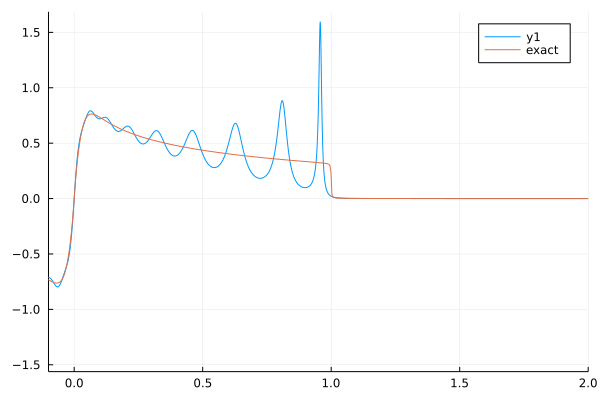

In [54]:
plot(xlim = [-0.1,2])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(real.(raw_reals.freq), (imag.(raw_reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)))
plot!(real.(exa_freq), imag.(exa_chi)/pi,label="exact")

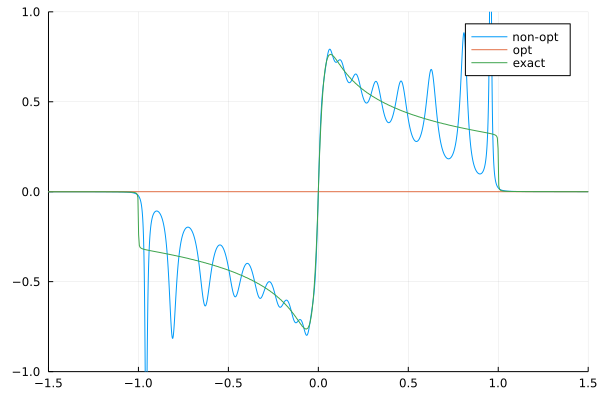

In [55]:
plot(xlim = [-1.5,1.5],ylim= [-1.0,1.0])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt", marker=:+)
plot!(real.(raw_reals.freq), (imag.(raw_reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(raw_reals.freq)),label="non-opt")
plot!(Float64.(real.((sol_reals.freq))), Float64.(imag.(sol_reals.val/pi)).*tanh.(0.5*SparseIR.β(basis)*real.(sol_reals.freq)),label="opt")
#plot!(Float64.(real.((sol_reals.freq))), Float64.(imag.(sol_reals.val/pi)-rho.(real.(sol_reals.freq))).*tanh.(0.5*SparseIR.β(basis)*real.(sol.reals.freq)),label="opt")
plot!(real.(exa_freq), imag.(exa_chi)/pi,label="exact")

In [56]:
plot(xlim = [-2,2])
#plot!(real.(raw_reals.freq), imag.(raw_reals.val/(pi*scale)),marker=:+)
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val/(pi*scale))))
plot!(real.(raw_reals.freq), imag.(raw_reals.val/pi),marker=:+)
plot!(Float64.(real.((sol_reals.freq))), Float64.(imag.(sol_reals.val/pi)))

In [37]:
ComplexF64.(raw_reals.freq[1])

-2.0 + 0.001im